$ h_{out} = \frac{1}{2}$

# Convolucional Neuronal Network

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# 
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

## Upload database

In [2]:
data_path = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets'
num_train = 50000
num_val = 5000
num_test = 5000
batch_size = 64


transform_cifar = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
])

# Training set
cifar10_train = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transform_cifar)
train_loader = DataLoader(
    cifar10_train,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_train)))

# Validation set
cifar10_val = datasets.CIFAR10(
    data_path,
    train= False,
    download=True,
    transform=transform_cifar)
val_loader = DataLoader(
    cifar10_val,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_val)))

# Test set
cifar10_test = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform= transform_cifar)
test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
    sampler=sampler.SubsetRandomSampler(range(num_test, num_test + num_val))
)


In [3]:
# this make a generator
data_iter = iter(train_loader)
# get the first batch
images, labels = next(data_iter)
print(images.shape)

torch.Size([64, 3, 32, 32])


# Choose Device

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Show images

Show the image 0 of the batch 7. Class: 


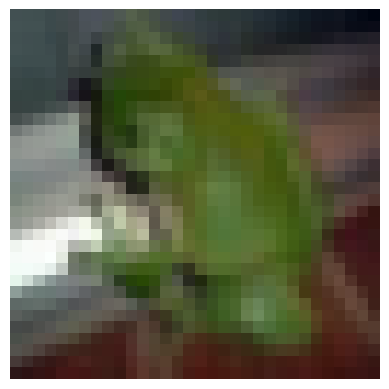

In [5]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

idx= np.random.randint(len(test_loader))
print(f'Show the image 0 of the batch {idx}. Class: ')
image = test_loader.dataset[idx][0]
image = (image- image.min())/(image.max()-image.min())
plot_figure(image)

# Accuracy


In [6]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device)
            yi = yi.to(device)
            scores = model(xi)
            # Compute the max in each row for each image of the batch
            _, preds = scores.max(1)
            num_correct += (preds == yi).sum()
            num_total += len(yi)
        return float(num_correct) / num_total

# Training Loop

In [7]:
def train(model, optimizer, epochs=100):
    model = model.to(device = device)
    for epoch in range(epochs):
        model.train()
        for (xi, yi) in train_loader:
            xi = xi.to(device = device, dtype=torch.float32)
            yi = yi.to(device = device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi.squeeze())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, val_loader)
        if epoch%1 == 0:
            print(f'Epoch {epoch}, Cost: {cost.item()}, accuracy: {acc}')


# Secuential linear

In [8]:
hidden1 = 256
hidden2 = 256
lr = 1e-3
epochs = 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features = 3*32*32, out_features=hidden1), nn.ReLU(),
    nn.Linear(in_features = hidden1, out_features=hidden2), nn.ReLU(),
    nn.Linear(in_features = hidden2, out_features=10), nn.ReLU()
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas= (0.9, 0.999))
train(model, optimizer, epochs=epochs)

Epoch 0, Cost: 1.4126169681549072, accuracy: 0.3842
Epoch 1, Cost: 1.751052737236023, accuracy: 0.4476
Epoch 2, Cost: 1.5607020854949951, accuracy: 0.4568
Epoch 3, Cost: 1.5625749826431274, accuracy: 0.5054
Epoch 4, Cost: 1.1747633218765259, accuracy: 0.5176
Epoch 5, Cost: 1.312883973121643, accuracy: 0.5238
Epoch 6, Cost: 1.3143444061279297, accuracy: 0.5248
Epoch 7, Cost: 0.93155837059021, accuracy: 0.5424
Epoch 8, Cost: 1.0614793300628662, accuracy: 0.5314
Epoch 9, Cost: 0.6877937316894531, accuracy: 0.5404


# Sequetial CNN

In [9]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN1 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=16*16*channel2, out_features=10)
)

optimizer = torch.optim.Adam(modelCNN1.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN1, optimizer, epochs=epochs)

Epoch 0, Cost: 1.190395712852478, accuracy: 0.6196
Epoch 1, Cost: 0.6175928711891174, accuracy: 0.6568
Epoch 2, Cost: 0.9208447933197021, accuracy: 0.668
Epoch 3, Cost: 0.5663272142410278, accuracy: 0.6658
Epoch 4, Cost: 0.7299443483352661, accuracy: 0.671
Epoch 5, Cost: 0.7757601141929626, accuracy: 0.669
Epoch 6, Cost: 1.0843104124069214, accuracy: 0.6644
Epoch 7, Cost: 0.6079903841018677, accuracy: 0.66
Epoch 8, Cost: 0.2677011489868164, accuracy: 0.658
Epoch 9, Cost: 0.6290624737739563, accuracy: 0.659


In [10]:
acc = accuracy(modelCNN1, test_loader)
print(f'Accuracy test: {acc}')

Accuracy test: 0.646


# OOP

In [11]:
class CNN_class1(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=channel1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [12]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN2 = CNN_class1(in_channels=3, channel1=channel1, channel2=channel2)
optimizer = torch.optim.Adam(modelCNN2.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN2, optimizer, epochs=epochs)

Epoch 0, Cost: 1.1882120370864868, accuracy: 0.6226
Epoch 1, Cost: 1.7210500240325928, accuracy: 0.6624
Epoch 2, Cost: 0.6148368716239929, accuracy: 0.6738
Epoch 3, Cost: 0.28657543659210205, accuracy: 0.6816
Epoch 4, Cost: 0.41394874453544617, accuracy: 0.6698
Epoch 5, Cost: 0.37266805768013, accuracy: 0.6668
Epoch 6, Cost: 1.093558430671692, accuracy: 0.6686
Epoch 7, Cost: 0.5645772814750671, accuracy: 0.669
Epoch 8, Cost: 0.39643940329551697, accuracy: 0.658
Epoch 9, Cost: 0.3360040783882141, accuracy: 0.6652


In [13]:
acc = accuracy(modelCNN2, test_loader)
print(f'Accuracy test: {acc}')

Accuracy test: 0.647


## A little more elegant

In [14]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
class CNN_class2(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class2, self).__init__()
        self.conv1 = conv_k_3(in_channels, channel1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = conv_k_3(channel1, channel2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [15]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN3 = CNN_class2(in_channels=3, channel1=channel1, channel2=channel2)
optimizer = torch.optim.Adam(modelCNN3.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN3, optimizer, epochs=epochs)

Epoch 0, Cost: 0.7606487274169922, accuracy: 0.6262
Epoch 1, Cost: 0.8576793074607849, accuracy: 0.6704
Epoch 2, Cost: 0.2783229947090149, accuracy: 0.6776
Epoch 3, Cost: 0.5572323203086853, accuracy: 0.6852
Epoch 4, Cost: 0.8928136825561523, accuracy: 0.6682
Epoch 5, Cost: 1.004603624343872, accuracy: 0.6726
Epoch 6, Cost: 1.216575264930725, accuracy: 0.676
Epoch 7, Cost: 0.27358055114746094, accuracy: 0.6638
Epoch 8, Cost: 0.48827487230300903, accuracy: 0.6616
Epoch 9, Cost: 0.5480047464370728, accuracy: 0.6486


# Batch Normalization

In [19]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
class CNN_class3(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class3, self).__init__()
        
        self.conv1 = conv_k_3(in_channels, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [20]:
channel1 = 16
channel2 = 32
epochs = 10
lr = 1e-3

modelCNN4 = CNN_class3(in_channels=3, channel1=channel1, channel2=channel2)
optimizer = torch.optim.Adam(modelCNN4.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN4, optimizer, epochs=epochs)

Epoch 0, Cost: 1.0528945922851562, accuracy: 0.588
Epoch 1, Cost: 0.9546079039573669, accuracy: 0.6432
Epoch 2, Cost: 1.220665693283081, accuracy: 0.674
Epoch 3, Cost: 0.6940227150917053, accuracy: 0.673
Epoch 4, Cost: 0.666777491569519, accuracy: 0.6634
Epoch 5, Cost: 0.5250480771064758, accuracy: 0.6884
Epoch 6, Cost: 1.1143407821655273, accuracy: 0.6806
Epoch 7, Cost: 0.8966401219367981, accuracy: 0.6876
Epoch 8, Cost: 0.7281394600868225, accuracy: 0.6724
Epoch 9, Cost: 0.24208472669124603, accuracy: 0.6762


# USING POO and Sequential

In [21]:
conv_k_3 = lambda channel1, channel2: nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, stride=1, padding=1)
class CNN_class4(nn.Module):
    def __init__(self, in_channels, channel1, channel2):
        super(CNN_class4, self).__init__()
        
        self.conv1 = conv_k_3(in_channels, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)

        self.conv2 = conv_k_3(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.flatten = nn.Flatten()
        # self.fc = nn.Linear(in_features=16*16*channel2, out_features=10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        return x

In [22]:
channel1 = 16
channel2 = 32
channel3 = 64
channel4 = 128

epochs = 10
lr = 1e-3

modelCNN5 = nn.Sequential(
    CNN_class4(in_channels=3, channel1=channel1, channel2=channel2),
    CNN_class4(in_channels=channel2, channel1=channel3, channel2=channel4),
    nn.Flatten(),
    nn.Linear(in_features=8*8*channel4, out_features=10),
    
)

optimizer = torch.optim.Adam(modelCNN5.parameters(), lr=lr, betas= (0.9, 0.999))
train(modelCNN5, optimizer, epochs=epochs)

Epoch 0, Cost: 1.2154837846755981, accuracy: 0.6316
Epoch 1, Cost: 0.9955135583877563, accuracy: 0.7136
Epoch 2, Cost: 0.9092562794685364, accuracy: 0.7098
Epoch 3, Cost: 0.30186161398887634, accuracy: 0.7462
Epoch 4, Cost: 0.80680912733078, accuracy: 0.7704
Epoch 5, Cost: 0.5231899619102478, accuracy: 0.7828
Epoch 6, Cost: 1.3443899154663086, accuracy: 0.755
Epoch 7, Cost: 0.16051079332828522, accuracy: 0.7784
Epoch 8, Cost: 0.1875312626361847, accuracy: 0.7794
Epoch 9, Cost: 0.263700395822525, accuracy: 0.7792
